Let's add:
- data augmentatioon
- clearer separation of featurization and training
- pipelines in training for generating multiple datasets
- out-of-sample inferencing

In [309]:
from mrcs_loader import get_all_imgs_from_paths, get_files_of_type_from_path, load_paths_into_array
import os
from tqdm import tqdm
import numpy as np

# For featurizer
import itertools
from matplotlib import pyplot as plt
from sklearn import decomposition
from time import time
from sklearn.preprocessing import StandardScaler

# For image tf
from skimage import filters
from scipy import ndimage
import cv2
from scipy import fftpack, ndimage, signal


# For GBDT
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score
import pandas as pd
import lightgbm as lgb
from sklearn.svm import SVC
import numpy.random as nr



# Create Dataset

In [20]:
# Data path
data_path = '../../data/Extract/'

# Paths of good/bad .mrcs files
good_path_in = os.path.join(data_path, 'job028/micrographs')
bad_path_in = os.path.join(data_path, 'job031/micrographs')

# Paths to store good/bad .pkl files
good_path_out = os.path.join(data_path, 'dataset0/good')
bad_path_out = os.path.join(data_path, 'dataset0/bad')


data_file_ext = '_lowpass.mrcs'
#ata_file_ext = 'dfpt.mrcs'

data_paths = {'good':get_files_of_type_from_path(good_path_in, data_file_ext),  
              'bad':get_files_of_type_from_path(bad_path_in, data_file_ext)}

data = {'good': get_all_imgs_from_paths(data_paths['good']),
        'bad': get_all_imgs_from_paths(data_paths['bad'])}


In [325]:
class ImageTransform():
    def __init__(self):
        self.name = None

    def transform(self, arr):
        '''
        Apply transform to single array
        '''
        return arr

    def apply(self, data):
        print("Applying transform: "+self.name)
        return [self.transform(x) for x in data]


class IdentityTransform(ImageTransform):
    def __init__(self, resized_shape=(28,28)):
        super().__init__()
        self.name = "Identity"
        self.resized_shape = resized_shape


class FuncTransform(ImageTransform):
    def __init__(self, func=None, ):
        super().__init__()
        self.name = "Identity"
        self.resized_shape = resized_shape
        

class RobertsTransform(ImageTransform):
    def __init__(self):#, resized_shape=(28,28)):
        super().__init__()
        self.name = "Roberts"
        #self.resized_shape = resized_shape

    def transform(self, arr):
        # Resize
        #res = cv2.resize(arr, dsize=self.resized_shape, interpolation=cv2.INTER_LINEAR)

        # Filter
        return filters.roberts(arr)
    
    
class Resize(ImageTransform):
    def __init__(self, resized_shape=[None, None]):
        super().__init__()
        self.name="Resize({}x{})".format(*resized_shape)
        
    def transform(self, arr):
        res = cv2.resize(arr, dsize=self.resized_shape, interpolation=cv2.INTER_LINEAR)
        
        return res
    
    
class PyrDown(ImageTransform):
    def __init__(self):
        super().__init__()
        self.name="PyrDown"
        
    def transform(self, arr):
        return cv2.pyrDown(arr)


class FFT2Transform(ImageTransform):
    def __init__(self, central_width=None):
        super().__init__()
        self.name = "FFT2"
        self.central_width = central_width

    def transform(self, arr):
        # Get absolute values of 2D FFT, with centrally shifting
        fft2 = np.fft.fftshift(np.abs(fftpack.fft2(arr)))

        # Get center crop
        H, W = fft2.shape
        C = self.central_width
        if C is not None:
            tf_arr = fft2[int((H-C)/2):int((H-C)/2)+C, int((W-C)/2):int((W-C)/2)+C]
        else:
            tf_arr = fft2
        return tf_arr
    
    
class AutoCorrelation(ImageTransform):
    def __init__(self, mode="same", method="fft"):
        super().__init__()
        self.name = "AutoCorrelation"
        self.mode = mode
        self.method = method
        
    def transform(self, arr):
        return signal.correlate(arr, arr, mode=self.mode, method=self.method)
    
    
class MultiTransform(ImageTransform):
    def __init__(self, transforms):
        super().__init__()
        self.transforms = transforms
        self.name = '+'.join([x.name for x in self.transforms])
    
    def transform(self, arr):
        
        for t in self.transforms:
            arr = t.transform(t)
            
        return arr
    
    
class RandomRotation(ImageTransform):
    def __init__(self, rot_range=[0,360]):
        super().__init__()
        self.rot_range = rot_range
        self.name = "RandomRotation"
        
    def transform(self, arr):
        ang = nr.uniform(low=self.rot_range[0], high=self.rot_range[1])
        return ndimage.rotate(arr, ang, mode="reflect", reshape=False)
        
        

## Create Featurizer

In [285]:
class Featurizer():
    valid_estimator_names = ['PCA', 'FastICA', 'FactorAnalysis']
    
    def __init__(self, estimator_components={'PCA': 6, 'FastICA': 6}, label_prefix='', random_state=0):
        '''
        Calculates features on the flattened data (where each entry in the list is 
        interpreted as a sample of the M features)
          
        estimator_components: a dictionary of estimator name:n_component pairs to be calculated
        
        
        Example:
        > F = Featurizer(estimator_components={'PCA': 6, 'FastICA': 12})
        > F.fit(data)
        
        F.features: length (6+12) list of features
        F.feature_coeffs: [N, (6+12)] array of feature coefficients for each sample
        F.feature_labels: length (6+12) list of feature labels
        '''
        self._raw_data = data
        self.estimator_components = estimator_components
        
        self._preprocessed = False
        self._estimators_estimated = False
        self._features_featurized = False
        self.label_prefix = label_prefix
        
        self.random_state = random_state
        
    def fit(self, data):
        # data: a length-N list (data) of equally-sized numpy arrays with M elements,   
        
        # Flatten and Normalise data into contiguous array
        print("Preprocessing data . . .")
        scaled_data = self.preprocessData(data)
        
        # Fit estimators to data
        print("Fitting estimators . . .")
        self.getEstimators(scaled_data)
        
        # Calculate features
        print("Calculating features . . .")
        self.getFeatures(scaled_data)
        
        print("Done!")
        
    def _flattenData(self, data):
        data = np.stack(data, axis=0)
        raw_data_shape = data.shape
        data = data.reshape(raw_data_shape[0], -1)
        
        return data, raw_data_shape
    
    def preprocessData(self, data):
        # Stack into contiguous array
        data, self._raw_data_shape = self._flattenData(data)
        
        
        # Zero-mean and unit-variance rescaling
        self._scaler = StandardScaler()
        self._scaler.fit(data)
        data = self._scaler.transform(data)
        
        self._preprocessed = True
        
        return data
    
    def getEstimators(self, data):
        '''
        Makes list of ('name', estimator) pairs for PCA, ICA, FA
        and fits estimatorsto data
        '''
        if not self._preprocessed:
            raise ValueError("Data must be preprocessed and estimators constructed")
            
        self._estimators = []
        estimators = {'PCA': lambda n: decomposition.PCA(n_components=n, svd_solver='randomized',whiten=True, random_state=self.random_state),
                      'FastICA': lambda n:decomposition.FastICA(n_components=n, algorithm="deflation", whiten=True, random_state=self.random_state),
                      'FactorAnalysis': lambda n: decomposition.FactorAnalysis(n_components=n, random_state=self.random_state)}
        for name, n_comp in self.estimator_components.items():
            self._estimators.append( (name, estimators[name](n_comp)) )
            
        for name, estimator in self._estimators:
            print("Calculating %d features using %s..." % (estimator.n_components, name))
            t0 = time()
            estimator.fit(data)
            train_time = (time() - t0)
            print("\tTime taken = %0.3fs" % train_time)
            
        self._estimators_estimated = True
        
        
    def getFeatures(self, data):
        '''
        Concatenates all features from all estimators into a single list
        '''
        if not self._estimators_estimated:
            raise ValueError("Estimators must be fitted to data firts")
            
        #self._coeffs = {}
        features = []
#         feature_coeffs = []
#         feature_labels = []
        
        
        for name, estimator in self._estimators:
            features.append(estimator.components_.reshape(estimator.n_components,*self._raw_data_shape[1:]))
            
#             
        
        self.features = list(itertools.chain.from_iterable(features))
#         self.feature_coeffs = np.concatenate(feature_coeffs, axis=1)
#         self.feature_labels = list(itertools.chain.from_iterable(feature_labels))
        
        self._features_featurized = True
        
    
    def getCoeffs(self, raw_data):
        '''
        Calculates coefficients of raw data with respect to each estimator
        Note requires the UNSCALED data
        '''
        data, data_shape = self._flattenData(raw_data)
        
        data = self._scaler.transform(data)
        feature_coeffs = []
        feature_labels = []
        
        for name, estimator in self._estimators:
            coeffs = estimator.transform(data)
            #coeffs = np.matmul(estimator.components_, self.data.T).T
            feature_coeffs.append(coeffs)
            
            labels = []
            for i in range(estimator.n_components):
                labels.append("{} {}".format(self.label_prefix+name, i))
            feature_labels.append(labels)
            
        feature_coeffs = np.concatenate(feature_coeffs, axis=1)
        feature_labels = list(itertools.chain.from_iterable(feature_labels))
        
        return feature_coeffs, feature_labels
        
        
    def plot2DComponents(self, n_col = 3, cmap=plt.cm.gray):
        '''
        Makes a figure showing the components identified by each estimator
        Note that this will not work for non-image data
        
        n_col: number of columns in each plotted figure
        cmap: colormap to use for plotted 2D components
        '''
        
        # check that we're using 3D data
        if len(self._raw_data_shape)!=3:          
            raise ValueError("Cannot plot 2D components for non-2D data")
            
        # Check that we've actually calculated features
        if not self._estimators_estimated:
            raise ValueError("Estimators need to be fitted to data before plotting")
        
        
        image_shape = (self._raw_data_shape[1], self._raw_data_shape[2])
        
        for name, estimator in self._estimators:
            n_row = int(np.ceil(estimator.n_components/n_col))
            plt.figure(figsize=(2. * n_col, 2.26 * n_row))
            plt.suptitle(name, size=16)
            for i, comp in enumerate(estimator.components_):
                plt.subplot(n_row, n_col, i + 1)
                vmax = max(comp.max(), -comp.min())
                plt.imshow(comp.reshape(image_shape), cmap=cmap,
                           interpolation='nearest',
                           vmin=-vmax, vmax=vmax)
                plt.xticks(())
                plt.yticks(())
            plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

In [286]:
class PipelinedFeaturizer():
    valid_estimator_names = ['PCA', 'FastICA', 'FactorAnalysis']
    
    def __init__(self,  transform_pipeline=[IdentityTransform()], 
                        transform_preprocessing=[[IdentityTransform(), FFT2Transform(), RobertsTransform()]],
                        estimator_components=[{'PCA': 6, 'FastICA': 6}]
                        ):
        '''
        data: an nd-array of the dataset, where the outermost dimension corresponds to the sample index
        transform_pipeline: a length `P` list of transforms to be successively applied to each sample in `data` to generate new datasets
        transform_preprocessing: a length `P` list of lists of transforms to be individually applied to each dataset generated from each stage of `transform_pipeline`
        estimator_components: a length `P` list of dictionaries of estimator name:component pairs. Valid keys are "PCA", "FastICA", and "FactorAnalysis"
        
        e.g.:
        > P = PipelinedFeaturizer(
        >     transform_pipeline=[IdentityTransform(), PyrDown(), PyrDown(), PyrDown()],
        >     transform_preprocessing=[[IdentityTransform()], [IdentityTransform(), FFT2Transform(central_width=50), AutoCorrelation()], [], [RobertsTransform()]],
        >     estimator_components=[{'PCA': 21, 'FastICA': 21}, {'PCA': 21, 'FastICA': 21}, {'PCA': 9, 'FastICA':9}, {'PCA': 21, 'FastICA': 21}])
        > P.fit(data_aug)
        > coeff_labels, coeffs = P.getCoeffs(data_all)
        '''
        
        #self.raw_data = data
        self.transform_pipeline = transform_pipeline
        self.transform_preprocessing = transform_preprocessing
        
        # Check keys in estimator compoents            if 
        for ec in estimator_components:
            if not all([x in self.valid_estimator_names for x in ec.keys()]):
                raise ValueError("Invalid key(s) in estimator_components")
        self.estimator_components = estimator_components
        
    def fit(self, raw_data):
        # 
        self.Featurizers = []
        
        # Iterate over successive pipeline transformations
        pipe_prefix = ''
        pipe_data = raw_data
        for i_pipe, tf_pipe in enumerate(self.transform_pipeline):
            print("Processing pipeline transform %d of %d"%(i_pipe+1, len(self.transform_pipeline)))
            if i_pipe!=0:
                pipe_prefix = pipe_prefix+"+"
            pipe_prefix = pipe_prefix + tf_pipe.name
            
            pipe_data = tf_pipe.apply(pipe_data)
            
            pipe_features = []
            
            # Iterate over preprocessing transformations
            if len(self.transform_preprocessing[i_pipe])!=0:
                for i_prep, tf_prep in enumerate(self.transform_preprocessing[i_pipe]):

                    print("Processing preprocessing transform %d of %d"%(i_prep+1, len(self.transform_preprocessing[i_pipe])))
                    prep_prefix = pipe_prefix + "+" + tf_prep.name

                    data = tf_prep.apply(pipe_data)


                    F = Featurizer(estimator_components=self.estimator_components[i_pipe], label_prefix=prep_prefix+' ')
                    F.fit(data)
                    pipe_features.append(F)
                    
            else:
                pipe_features.append(None)
                    

                # Append generated features
            self.Featurizers.append( (pipe_prefix, pipe_features))
            
    def getCoeffs(self, raw_data):
        '''
        Calculates coefficients with respect to each featurizer
        '''
        # Iterate over successive pipeline transformations
        pipe_data = raw_data
        coeffs = []
        labels = []
        
        for i_pipe, tf_pipe in enumerate(self.transform_pipeline):
            print("Processing pipeline transform %d of %d"%(i_pipe+1, len(self.transform_pipeline)))
            pipe_data = tf_pipe.apply(pipe_data)
            
            # Iterate over preprocessing transformations
            if len(self.transform_preprocessing[i_pipe])!=0:
                for i_prep, tf_prep in enumerate(self.transform_preprocessing[i_pipe]):
                    print("Processing preprocessing transform %d of %d"%(i_prep+1, len(self.transform_preprocessing[i_pipe])))
                    data = tf_prep.apply(pipe_data)

                    feature_coeffs, feature_labels = self.Featurizers[i_pipe][1][i_prep].getCoeffs(data)

                    coeffs.append(feature_coeffs)
                    labels.append(feature_labels)
        
        coeffs = np.concatenate(coeffs, axis=1)
        labels = list(itertools.chain.from_iterable(labels))
        
        return labels, coeffs
            
        
    

In [ ]:
class GBDT():
    def __init__(self, x, y, x_labels=None, params=None, random_state=0, test_size=0.3):
        '''
        A convenience wrapper for training a GBDT
        x: NxM array of N samples of M dependent variables
        y: N array of labels for each of the N samples
        
        '''
        self._trained = False
        
        self.x = x
        self.x_labels = x_labels
        self.Y = y
        
        self.random_state = random_state
        self.test_size = test_size
        
        # Normalise x data
        self._scaler = StandardScaler()
        if self.x_labels is not None:
            columns = [x+' normed' for x in self.x_labels]
        else:
            columns = None
        self.X = pd.DataFrame(self._scaler.fit_transform(self.x),
                              columns = columns)
        
        # Make test/train split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.Y, test_size=self.test_size, random_state=self.random_state)
        
        # Convert to LGB format
        self.lgb_dataset = lgb.Dataset(self.X_train, label=self.y_train)
        
    
    def train(self, epochs=10000, params=None, random_state=0):
        if params is None:
            params={
            "objective" : "binary",
            "metric" : "auc",
            "boosting": 'gbdt',
            "max_depth" : -1,
            "learning_rate" : 0.01,
            "verbosity" : 1,
            "seed": random_state
            }
        self.params = params
        
        print('Training GBDT . . .')
        self.model = lgb.train(self.params, self.lgb_dataset, epochs)
        self._trained = True
        print('Done!')
        
        
    def plotROC(self):
        if not self._trained:
            raise ValueError("Need to train model first")
        
        # generate a no skill prediction (majority class)
        ns_probs = [0 for _ in range(len(self.y_test))]

        # predict probabilities
        lr_probs = self.model.predict(self.X_test)

        # calculate scores
        ns_auc = roc_auc_score(self.y_test, ns_probs)
        lr_auc = roc_auc_score(self.y_test, lr_probs)

        # summarize scores
        print('No Skill: ROC AUC=%.3f' % (ns_auc))
        print('Logistic: ROC AUC=%.3f' % (lr_auc))

        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(self.y_test, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(self.y_test, lr_probs)

        # plot the roc curve for the model
        plt.figure(figsize=(5,5), dpi= 200)
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

        # show the plot
        plt.title("ROC for GBM using PCA/ICA/FA Features", fontweight='bold')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.grid()
        plt.show()

        
class SVCModel():
    def __init__(self, x, y, x_labels=None, random_state=0, test_size=0.3):
        '''
        A convenience wrapper for training a SVC
        x: NxM array of N samples of M dependent variables
        y: N array of labels for each of the N samples
        
        '''
        self._trained = False
        
        self.x = x
        self.x_labels = x_labels
        self.Y = y
        
        self.random_state = random_state
        self.test_size = test_size
        
        # Normalise x data
#         self._scaler = StandardScaler()
#         self.X = self._scaler.fit_transform(self.x)
        # Normalise x data
        self._scaler = StandardScaler()
        if self.x_labels is not None:
            columns = [x+' normed' for x in self.x_labels]
        else:
            columns = None
        self.X = pd.DataFrame(self._scaler.fit_transform(self.x),
                              columns = columns)
        
        # Make test/train split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.Y, test_size=self.test_size, random_state=self.random_state)
        
        
    def train(self, kernel='rbf', gamma='auto', random_state=0):
        self.svc = SVC(kernel=kernel, gamma=gamma, probability=True)
        print('Training SVC . . .')
        self.model = self.svc.fit(self.X_train, self.y_train)
        self._trained = True
        print('Done!')
        
        
    def plotROC(self):
        if not self._trained:
            raise ValueError("Need to train model first")
        
        # generate a no skill prediction (majority class)
        ns_probs = [0 for _ in range(len(self.y_test))]

        # predict probabilities
        lr_probs = self.model.predict(self.X_test)

        # calculate scores
        ns_auc = roc_auc_score(self.y_test, ns_probs)
        lr_auc = roc_auc_score(self.y_test, lr_probs)

        # summarize scores
        print('No Skill: ROC AUC=%.3f' % (ns_auc))
        print('Logistic: ROC AUC=%.3f' % (lr_auc))

        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(self.y_test, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(self.y_test, lr_probs)

        # plot the roc curve for the model
        plt.figure(figsize=(5,5), dpi= 200)
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

        # show the plot
        plt.title("ROC for SVC using PCA/ICA/FA Features", fontweight='bold')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.grid()
        plt.show()
        
        
class GBDT_PreTTS(GBDT):
    def __init__(self, X_train, X_test, y_train, y_test, x_labels=None, params=None, random_state=0):
        '''
        A convenience wrapper for training a GBDT
        x: NxM array of N samples of M dependent variables
        y: N array of labels for each of the N samples
        
        '''
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self._trained = False
        self.x_labels = x_labels
        
        
        self.random_state = random_state
        
        
        self.X_train = pd.DataFrame(self.X_train,
                              columns = [x+' normed' for x in self.x_labels])
        
        # Convert to LGB format
        self.lgb_dataset = lgb.Dataset(self.X_train, label=self.y_train)
        
    
        
class SVCModel_PreTTS(SVCModel):
    def __init__(self,X_train, X_test, y_train, y_test, x_labels=None, params=None, random_state=0):
        '''
        A convenience wrapper for training a SVC
        x: NxM array of N samples of M dependent variables
        y: N array of labels for each of the N samples
        
        '''
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self._trained = False
        self.x_labels = x_labels
        
        
        self.random_state = random_state
        

# Augment feature data

In [333]:
data_all = data['good']+data['bad']
#F = Featurizer(estimator_components={'PCA': 21, 'FastICA': 15, "FactorAnalysis":7})

In [354]:
class DataAugmenter(object):  
    def __init__(self, transform, n_rounds):
        self.transform = transform
        self.n_rounds = n_rounds
    
    def aug(self, data):
        data_aug = data.copy()
        for i in range(self.n_rounds):
            data_aug.extend(self.transform.apply(data))
            
        return data_aug
        

In [335]:
data_aug = DataAugmenter.aug(data_all, RandomRotation(), 3)

Applying transform: RandomRotation
Applying transform: RandomRotation
Applying transform: RandomRotation


In [337]:
len(data_all)

1980

In [338]:
len(data_aug)

7920

In [403]:
P = PipelinedFeaturizer(transform_pipeline=[IdentityTransform(), PyrDown(), PyrDown(), PyrDown()],
                        transform_preprocessing=[[IdentityTransform()], [IdentityTransform(), FFT2Transform(central_width=50), AutoCorrelation()], [], [RobertsTransform()]],
                        estimator_components=[{'PCA': 21, 'FastICA': 21}, {'PCA': 21, 'FastICA': 21}, {'PCA': 9, 'FastICA':9}, {'PCA': 21, 'FastICA': 21}])

In [404]:
P.fit(data_aug)

Processing pipeline transform 1 of 4
Applying transform: Identity
Processing preprocessing transform 1 of 1
Applying transform: Identity
Preprocessing data . . .
Fitting estimators . . .
Calculating 21 features using PCA...
	Time taken = 6.168s
Calculating 21 features using FastICA...
	Time taken = 166.488s
Calculating features . . .
Done!
Processing pipeline transform 2 of 4
Applying transform: PyrDown
Processing preprocessing transform 1 of 3
Applying transform: Identity
Preprocessing data . . .
Fitting estimators . . .
Calculating 21 features using PCA...
	Time taken = 1.728s
Calculating 21 features using FastICA...
	Time taken = 139.998s
Calculating features . . .
Done!
Processing preprocessing transform 2 of 3
Applying transform: FFT2
Preprocessing data . . .
Fitting estimators . . .
Calculating 21 features using PCA...
	Time taken = 0.328s
Calculating 21 features using FastICA...
	Time taken = 46.045s
Calculating features . . .
Done!
Processing preprocessing transform 3 of 3
Appl

In [405]:
L,C = P.getCoeffs(data_all)

Processing pipeline transform 1 of 4
Applying transform: Identity
Processing preprocessing transform 1 of 1
Applying transform: Identity
Processing pipeline transform 2 of 4
Applying transform: PyrDown
Processing preprocessing transform 1 of 3
Applying transform: Identity
Processing preprocessing transform 2 of 3
Applying transform: FFT2
Processing preprocessing transform 3 of 3
Applying transform: AutoCorrelation
Processing pipeline transform 3 of 4
Applying transform: PyrDown
Processing pipeline transform 4 of 4
Applying transform: PyrDown
Processing preprocessing transform 1 of 1
Applying transform: Roberts


# Augment training data

In [406]:
target_labels = np.concatenate([np.ones(len(data['good'])), np.zeros(len(data['bad']))], axis=0)

In [407]:
augmenter = DataAugmenter(RandomRotation(), 3)

In [408]:
class TestTrainSplitter():
    def __init__(self, X, Y, test_size=0.3, random_state=0):
        self.random_state = random_state
        self.test_size = 0.3
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, Y, test_size=self.test_size, random_state=self.random_state)
        
    def augment_train(self, augmenter):
        self.X_train = augmenter.aug(self.X_train)
        self.y_train = np.tile(self.y_train, augmenter.n_rounds+1)

In [409]:
TTS = TestTrainSplitter(data_all, target_labels)
TTS.augment_train(augmenter)

Applying transform: RandomRotation
Applying transform: RandomRotation
Applying transform: RandomRotation


In [410]:
# Get coeffs for Train/Test
L_train, C_train = P.getCoeffs(TTS.X_train)
L_test, C_test = P.getCoeffs(TTS.X_test)

Processing pipeline transform 1 of 4
Applying transform: Identity
Processing preprocessing transform 1 of 1
Applying transform: Identity
Processing pipeline transform 2 of 4
Applying transform: PyrDown
Processing preprocessing transform 1 of 3
Applying transform: Identity
Processing preprocessing transform 2 of 3
Applying transform: FFT2
Processing preprocessing transform 3 of 3
Applying transform: AutoCorrelation
Processing pipeline transform 3 of 4
Applying transform: PyrDown
Processing pipeline transform 4 of 4
Applying transform: PyrDown
Processing preprocessing transform 1 of 1
Applying transform: Roberts
Processing pipeline transform 1 of 4
Applying transform: Identity
Processing preprocessing transform 1 of 1
Applying transform: Identity
Processing pipeline transform 2 of 4
Applying transform: PyrDown
Processing preprocessing transform 1 of 3
Applying transform: Identity
Processing preprocessing transform 2 of 3
Applying transform: FFT2
Processing preprocessing transform 3 of 3


In [413]:
# Normalise coeffs
c_scaler = StandardScaler()
c_scaler.fit(np.concatenate([C_train, C_test], axis=0))


StandardScaler()

Training GBDT . . .
Done!
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.899


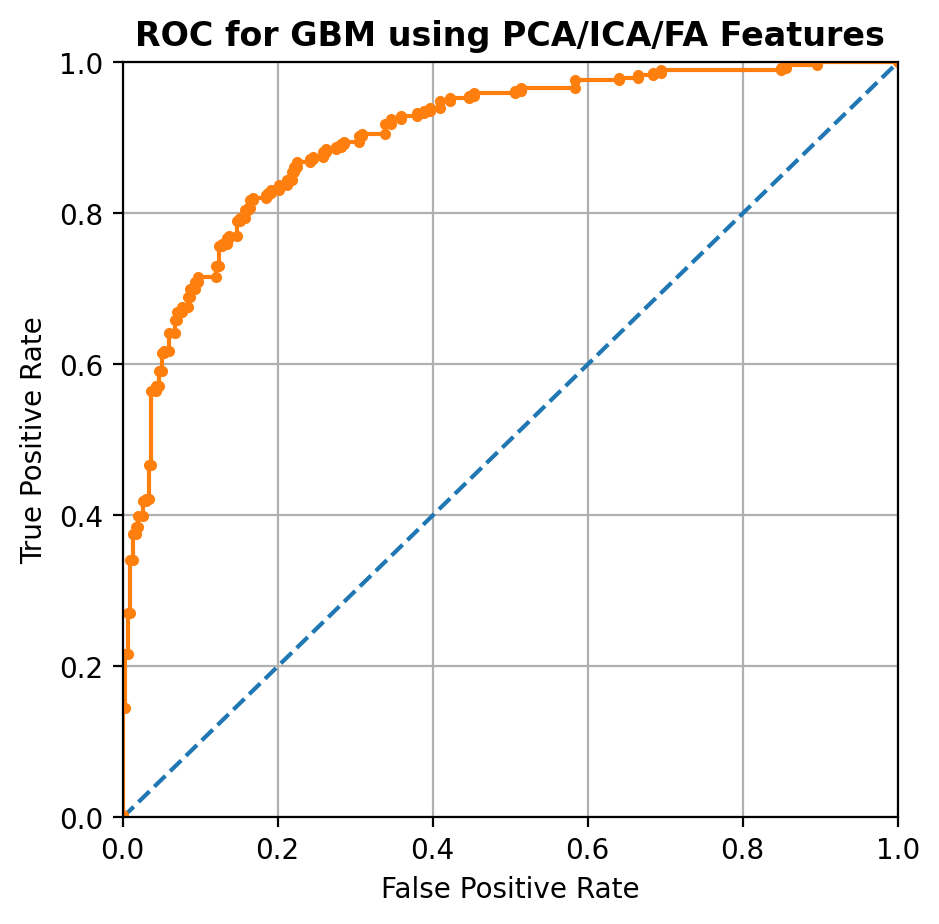

In [414]:
G = GBDT_PreTTS(c_scaler.transform(C_train), c_scaler.transform(C_test), TTS.y_train, TTS.y_test, x_labels=L_train)
G.train()
G.plotROC()

Training GBDT . . .
Done!
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.899


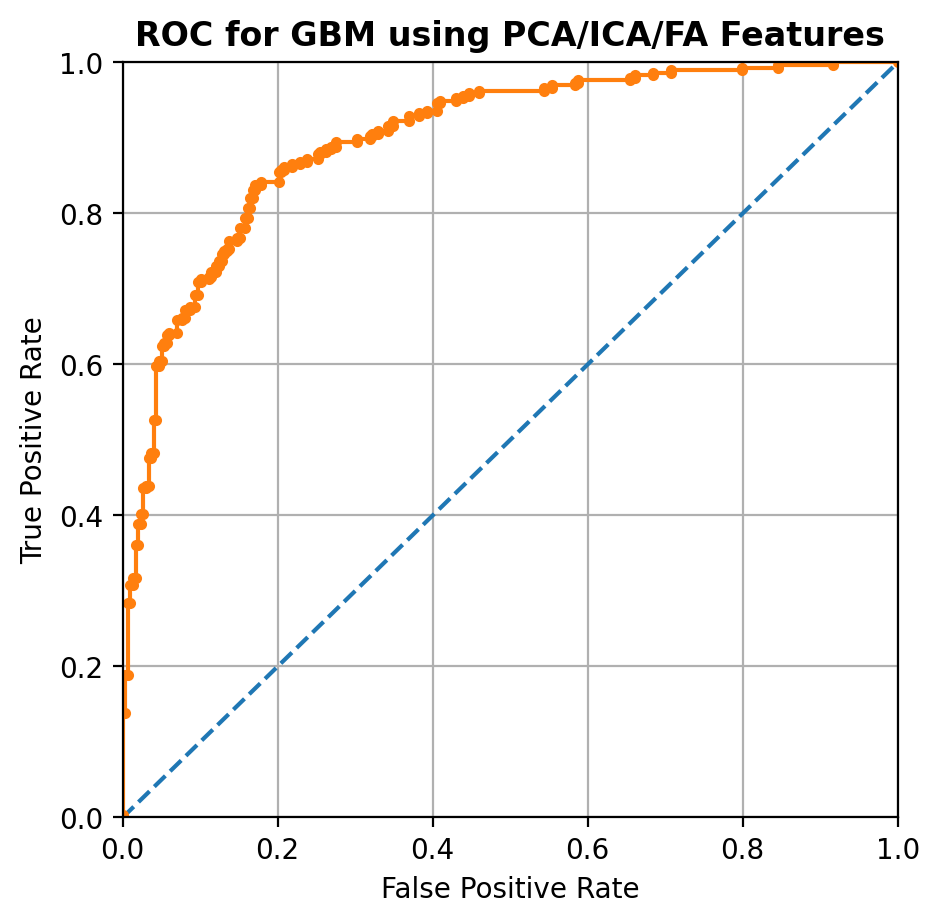

In [415]:
c_scalerG = GBDT_PreTTS(C_train, C_test, TTS.y_train, TTS.y_test, x_labels=L_train)
G.train()
G.plotROC()

Training SVC . . .
Done!
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.813


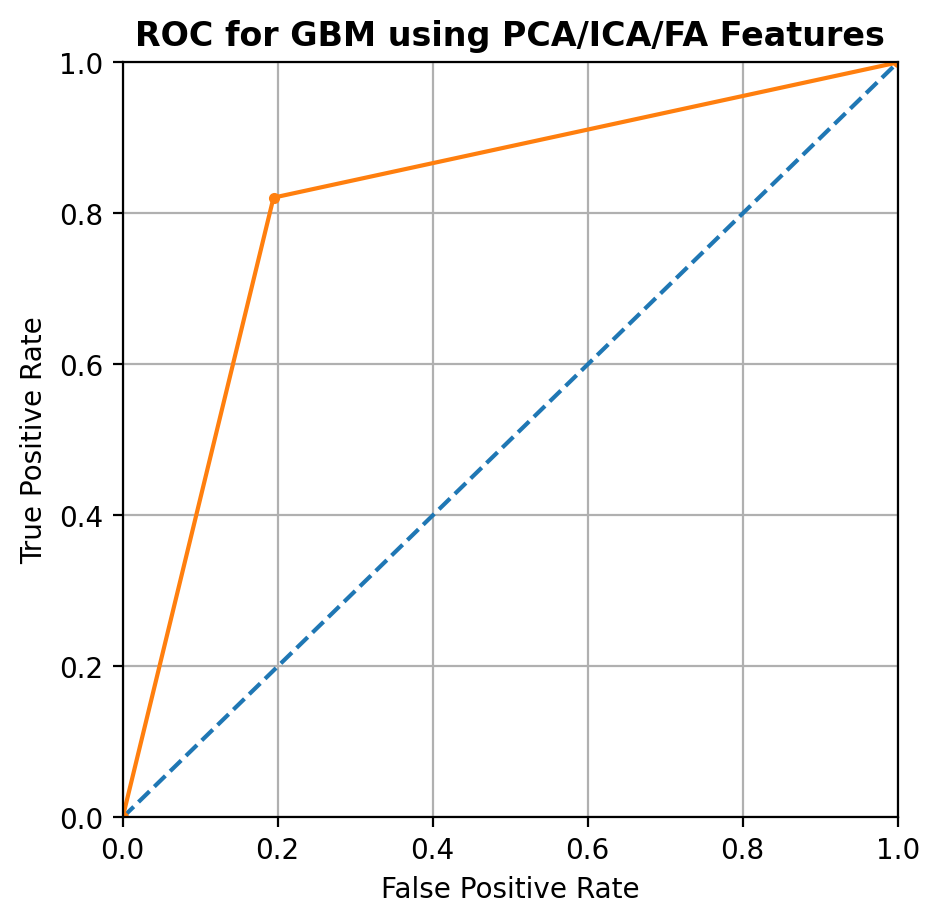

In [416]:
S = SVCModel_PreTTS(c_scaler.transform(C_train), c_scaler.transform(C_test), TTS.y_train, TTS.y_test, x_labels=L_train)
S.train()
S.plotROC()

Training SVC . . .
Done!
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.813


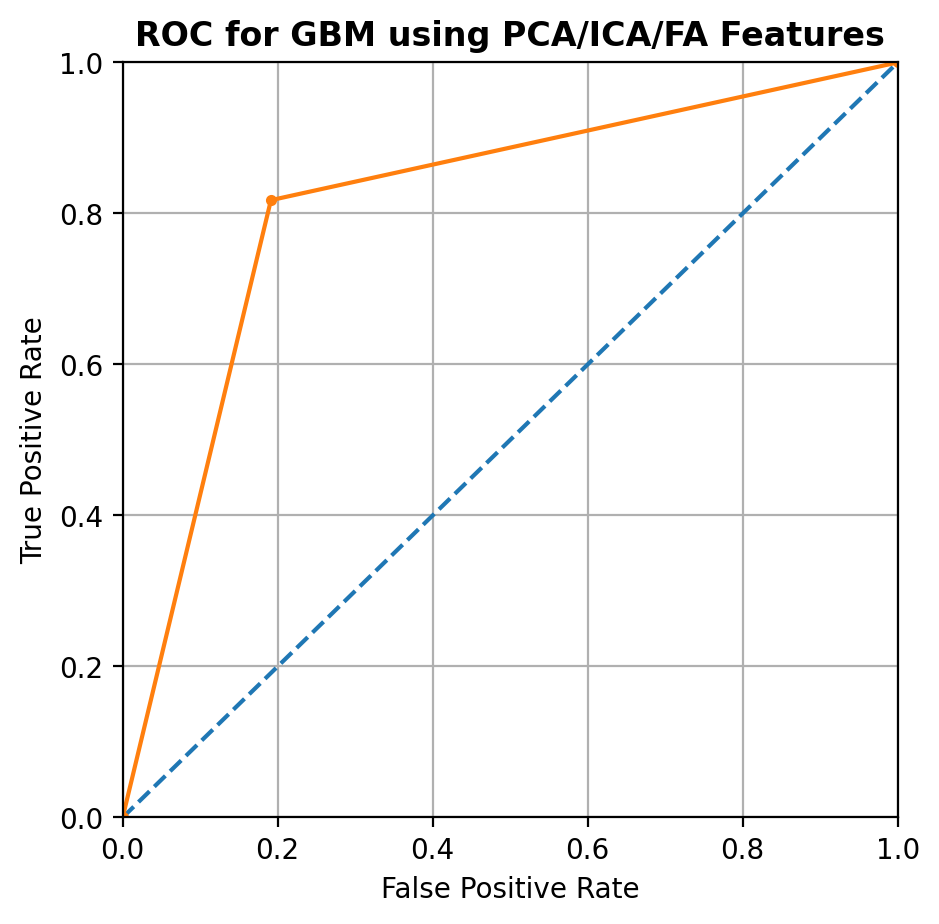

In [417]:
S = SVCModel_PreTTS(C_train, C_test, TTS.y_train, TTS.y_test, x_labels=L_train)
S.train()
S.plotROC()

# Test-Time Augmentation

In [ ]:
class GBDT_PreTTS_TTA(GBDT_PreTTS):
    def plotROC_TTA(self, augmenter):
        if not self._trained:
            raise ValueError("Need to train model first")
        
        # generate a no skill prediction (majority class)
        ns_probs = [0 for _ in range(len(self.y_test))]

        # predict probabilities
        lr_probs = self.model.predict(self.X_test)

        # calculate scores
        ns_auc = roc_auc_score(self.y_test, ns_probs)
        lr_auc = roc_auc_score(self.y_test, lr_probs)

        # summarize scores
        print('No Skill: ROC AUC=%.3f' % (ns_auc))
        print('Logistic: ROC AUC=%.3f' % (lr_auc))

        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(self.y_test, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(self.y_test, lr_probs)

        # plot the roc curve for the model
        plt.figure(figsize=(5,5), dpi= 200)
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

        # show the plot
        plt.title("ROC for SVC using PCA/ICA/FA Features", fontweight='bold')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.grid()
        plt.show()